# [CDAF] Atividade 3

## Nome e matrícula
Nome: Arthur Pontes Nader
Matrícula: 2019022294

## Referências
- [1] https://figshare.com/collections/Soccer_match_event_dataset/4415000
- [2] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.spadl.wyscout.convert_to_actions.html
- [3] https://github.com/TomDecroos/matplotsoccer
- [4] https://soccermatics.readthedocs.io/en/latest/gallery/lesson1/plot_PlottingShots.html
- [5] https://soccermatics.readthedocs.io/en/latest/gallery/lesson1/plot_PlottingPasses.html
- [6] https://soccermatics.readthedocs.io/en/latest/gallery/lesson1/plot_PassNetworks.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from socceraction.spadl import actiontypes_df, bodyparts_df, results_df, play_left_to_right
from socceraction.spadl.wyscout import convert_to_actions

import scipy.ndimage
import matplotsoccer
from mplsoccer import Pitch, Sbopen, VerticalPitch

## Questão 1
- Baixe o dataset 'Wyscout Europa Top 5 2017/2018' em [1].
- Escolha uma partida e carregue os dados de eventos em um dataframe do pandas.
- Converta os dados de eventos para SPADL [2].

In [2]:
competicoes = pd.read_json("competitions.json")
eventoid_para_nome = pd.read_csv("eventid2name.csv")
tags_para_nome = pd.read_csv("tags2name.csv")
jogadores = pd.read_json("players.json")
times = pd.read_json("teams.json")
eventos = pd.read_json("events_World_Cup.json")
eventos.tail()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
101754,8,Simple pass,[{'id': 1801}],3476,"[{'y': 20, 'x': 46}, {'y': 6, 'x': 64}]",2058017,Pass,9598,2H,2978.301867,85,263885652
101755,7,Touch,[],14812,"[{'y': 6, 'x': 64}, {'y': 2, 'x': 82}]",2058017,Others on the ball,9598,2H,2979.084611,72,263885653
101756,8,Cross,"[{'id': 401}, {'id': 801}, {'id': 1802}]",14812,"[{'y': 2, 'x': 82}, {'y': 100, 'x': 100}]",2058017,Pass,9598,2H,2983.448628,80,263885654
101757,4,Goalkeeper leaving line,[],25381,"[{'y': 0, 'x': 0}, {'y': 98, 'x': 18}]",2058017,Goalkeeper leaving line,4418,2H,2985.869275,40,263885613
101758,8,Launch,[{'id': 1802}],25381,"[{'y': 43, 'x': 14}, {'y': 0, 'x': 0}]",2058017,Pass,4418,2H,3002.148765,84,263885618


In [3]:
jogadores["player_id"] = jogadores["wyId"].copy()
jogadores["player_name"] = jogadores["firstName"] + " " + jogadores["lastName"]
jogadores_nomes = jogadores[["player_id", "player_name"]]

In [4]:
eventos_final = eventos[eventos["matchId"] == 2058017]

colunas_corretas = {'eventId':'type_id', 'subEventName':'subtype_name', 'playerId':'player_id',
              'matchId':'game_id', 'eventName':'type_name', 'teamId':'team_id',
              'eventSec':'milliseconds', 'subEventId':'subtype_id', 'id':'event_id'
              }
eventos_final = eventos_final.rename(columns=colunas_corretas)
eventos_final['period_id'] = pd.factorize(eventos_final['matchPeriod'])[0]+1

In [5]:
acoes = convert_to_actions(eventos_final, 4418)
acoes = play_left_to_right(acoes, 4418)
acoes = acoes.merge(jogadores_nomes, how='left')

acoes = ( acoes.merge( actiontypes_df(), how='left')
               .merge( results_df(), how='left' )
               .merge( bodyparts_df(), how='left' )
               .reset_index(drop=True) )

In [6]:
acoes['result_name'] = acoes['result_id'].replace({1: 'succes', 0: 'failure'})
acoes['team_name'] = acoes['team_id'].replace({4418: 'France', 9598: 'Croatia'})

In [7]:
acoes.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,player_name,type_name,result_name,bodypart_name,team_name
0,2058017,1,0.001892,9598,14943,52.50,33.32,52.50,33.32,263883958,0,0,1,0,Mario Mand\u017euki\u0107,pass,succes,foot,Croatia
1,2058017,1,0.002891,9598,69968,52.50,33.32,40.95,32.64,NaN,0,21,1,1,Marcelo Brozovi\u0107,dribble,succes,foot,Croatia
2,2058017,1,0.003889,9598,69968,40.95,32.64,35.70,17.68,263883959,0,0,1,2,Marcelo Brozovi\u0107,pass,succes,foot,Croatia
3,2058017,1,0.006141,9598,8287,35.70,17.68,31.50,4.76,263883960,0,0,1,3,Luka Modri\u0107,pass,succes,foot,Croatia
4,2058017,1,0.009227,9598,69409,31.50,4.76,11.55,23.80,263883963,0,0,1,4,\u0160ime Vrsaljko,pass,succes,foot,Croatia


## Questão 2
- Visualize uma sequência de 5 ações da partida usando matplotsoccer.actions [3].

In [8]:
sequencia = acoes[779:784]
sequencia

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,player_name,type_name,result_name,bodypart_name,team_name
779,2058017,2,1.168594,4418,279545,57.75,61.20,56.70,63.92,263885121,0,7,1,779,Lucas Hern\u00e1ndez Pi,take_on,succes,foot,France
780,2058017,2,1.168594,9598,14943,47.25,6.80,48.30,4.08,263885240,0,7,0,780,Mario Mand\u017euki\u0107,take_on,failure,foot,Croatia
781,2058017,2,1.170986,4418,279545,56.70,63.92,81.90,59.16,263885133,0,21,1,781,Lucas Hern\u00e1ndez Pi,dribble,succes,foot,France
782,2058017,2,1.174427,4418,279545,81.90,59.16,78.75,29.92,263885139,0,0,1,782,Lucas Hern\u00e1ndez Pi,pass,succes,foot,France
783,2058017,2,1.177059,4418,353833,78.75,29.92,105.00,37.40,263885135,0,11,1,783,Kylian Mbapp\u00e9 Lottin,shot,succes,foot,France


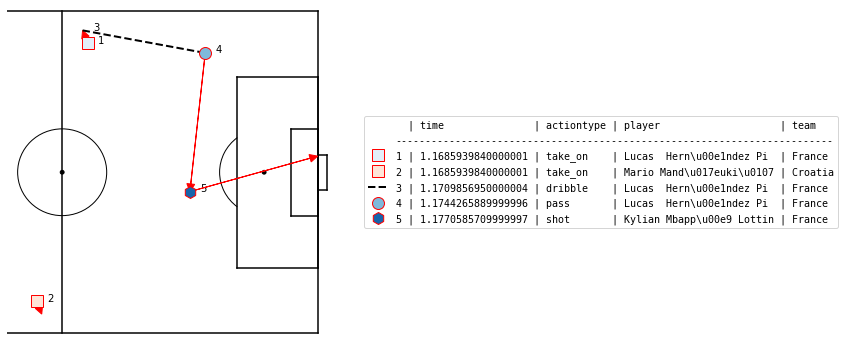

In [9]:
matplotsoccer.actions(
    location=sequencia[["start_x", "start_y", "end_x", "end_y"]],
    action_type=sequencia.type_name,
    team=sequencia.team_name,
    result= sequencia.result_name == "success",
    label=sequencia[["time_seconds", "type_name", "player_name", "team_name"]],
    labeltitle=["time","actiontype","player","team"],
    zoom=True
)

## Questão 3
- Visualize os chutes da partida, desenvolvendo seu código em cima do dataframe SPADL. Faça um plot para cada time. Adapte de [4].
- Qual time as melhores chances da partida? Por quê?

In [10]:
shots = acoes.loc[acoes['type_name'] == 'shot'].copy()
shots = shots.rename(columns={'start_x': 'x', 'start_y': 'y'})

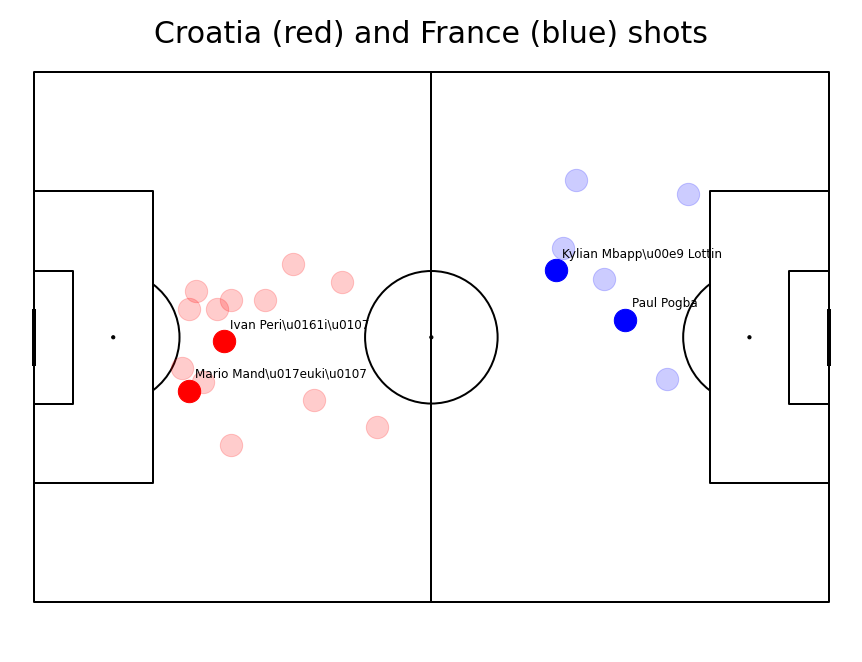

In [11]:
#create pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#query
mask_france = shots.team_name == "France"
#finding rows in the df and keeping only necessary columns
df_france = shots.loc[mask_france]

#plot them - if shot ended with Goal - alpha 1 and add name
#for England
for i, row in df_france.iterrows():
    if row["result_name"] == 'succes':
    #make circle
        pitch.scatter(row.x, row.y, alpha = 1, s = 500, color = "blue", ax=ax['pitch'])
        pitch.annotate(row["player_name"], (row.x + 1, row.y - 2), ax=ax['pitch'], fontsize = 12)
    else:
        pitch.scatter(row.x, row.y, alpha = 0.2, s = 500, color = "blue", ax=ax['pitch'])

mask_croatia = shots.team_name == "Croatia"
df_croatia = shots.loc[mask_croatia]

#for Sweden we need to revert coordinates
for i, row in df_croatia.iterrows():
    if row["result_name"] == 'succes':
        pitch.scatter(120 - row.x, 80 - row.y, alpha = 1, s = 500, color = "red", ax=ax['pitch'])
        pitch.annotate(row["player_name"], (120 - row.x + 1, 80 - row.y - 2), ax=ax['pitch'], fontsize = 12)
    else:
        pitch.scatter(120 - row.x, 80 - row.y, alpha = 0.2, s = 500, color = "red", ax=ax['pitch'])

fig.suptitle("Croatia (red) and France (blue) shots", fontsize = 30)
plt.show()

Pela imagem, pode parecer que a Croácia teve as melhores chances da partida, pois teve maior número de finalizações. Na verdade, o jogo terminou 4 a 2 para França, sendo que um gol de penâlti da França e um gol contra da Croacia não foram considerados como chutes.

## Questão 4
- Escolha um jogador da partida que você escolheu.
- Faça um heatmap de todas ações dele [3].
- Faça um heatmap de todas as ações ofensivas dele [3].
- Faça um heatmap de todas as ações defensivas dele [3].
- O que você pode inferir sobre o comportamento do jogador? O comportamento dele varia muito do ataque para a defesa?

In [12]:
acoes["type_name"].unique()

array(['pass', 'dribble', 'interception', 'throw_in', 'take_on', 'foul',
       'clearance', 'cross', 'goalkick', 'freekick_short',
       'corner_crossed', 'tackle', 'freekick_crossed', 'bad_touch',
       'keeper_save', 'shot', 'shot_penalty'], dtype=object)

In [13]:
jogador_id = 353833

acoes_jogador = acoes[acoes['player_id'] == jogador_id]
acoes_jogador = acoes_jogador.rename(columns={'start_x': 'x', 'start_y': 'y'})

acoes_defensivas = acoes_jogador[(acoes_jogador["type_name"] == "interception") |
                                 (acoes_jogador["type_name"] == "clearence") |
                                 (acoes_jogador["type_name"] == "tackle") |
                                 (acoes_jogador["type_name"] == "foul")
                                ].copy()

acoes_ofensivas = acoes_jogador[(acoes_jogador["type_name"] == "shot") |
                                (acoes_jogador["type_name"] == "dribble") |
                                (acoes_jogador["type_name"] == "freekick_short") |
                                (acoes_jogador["type_name"] == "take_on") |
                                (acoes_jogador["type_name"] == "cross")
                                ].copy()

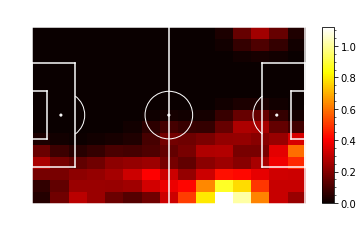

<AxesSubplot:>

In [14]:
x = acoes_jogador["x"]
y = acoes_jogador["y"]

hm = matplotsoccer.count(pd.Series(x), pd.Series(y), n=15, m=15)
hm = scipy.ndimage.gaussian_filter(hm, 1)
matplotsoccer.heatmap(hm, cmap="hot", linecolor="white", cbar=True)

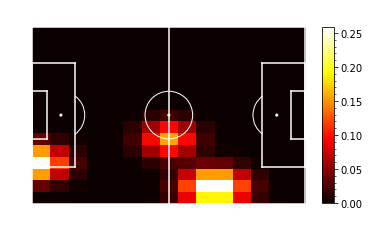

<AxesSubplot:>

In [15]:
x = acoes_defensivas["x"]
y = acoes_defensivas["y"]

hm = matplotsoccer.count(pd.Series(x), pd.Series(y), n=15, m=15)
hm = scipy.ndimage.gaussian_filter(hm, 1)
matplotsoccer.heatmap(hm, cmap="hot", linecolor="white", cbar=True)

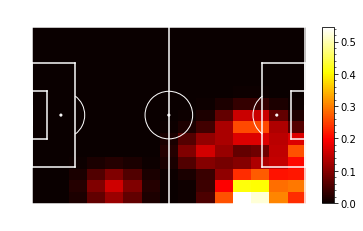

<AxesSubplot:>

In [16]:
x = acoes_ofensivas["x"]
y = acoes_ofensivas["y"]

hm = matplotsoccer.count(pd.Series(x), pd.Series(y), n=15, m=15)
hm = scipy.ndimage.gaussian_filter(hm, 1)
matplotsoccer.heatmap(hm, cmap="hot", linecolor="white", cbar=True)

Pode-se perceber que o comportamento do Kylian Mbappé, tal como esperado, é mais ofensivo e pela lateral do campo. Esse jogador possui pouca participação no jogo quando se trata de ações defensivas.

## Questão 5
- Para o mesmo jogador, crie um mapa de passes com os passes que ele efetuou na partida, desenvolvendo seu código em cima do dataframe SPADL. Adapte de [5].
- O mapa de passes trouxe alguma informação nova sobre o jogador?

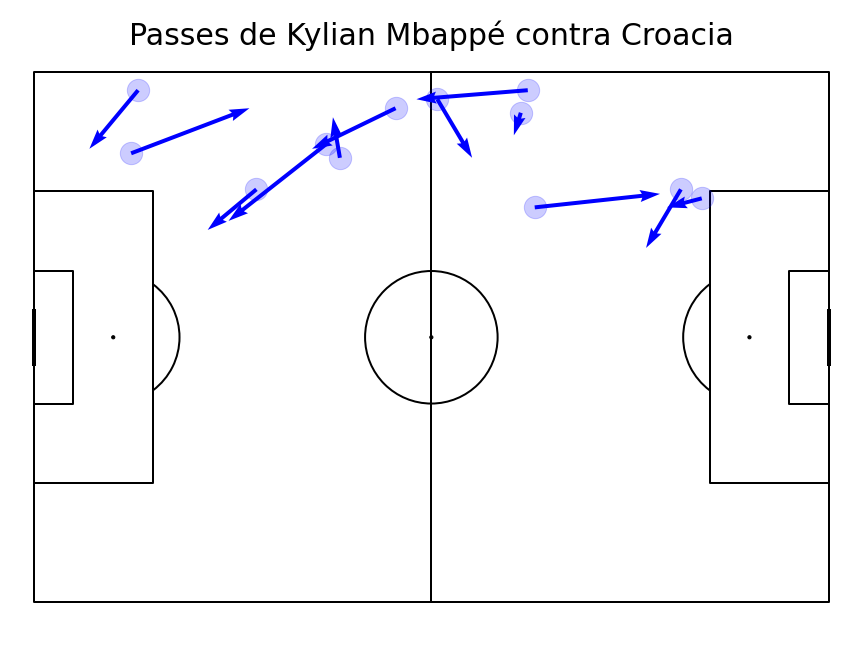

In [17]:
passes = acoes_jogador[acoes_jogador['type_name'] == 'pass']

pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.arrows(passes.x, passes.y,
             passes.end_x, passes.end_y, color = "blue", ax=ax['pitch'])
pitch.scatter(passes.x, passes.y, alpha = 0.2, s = 500, color = "blue", ax=ax['pitch'])
fig.suptitle("Passes de Kylian Mbappé contra Croacia", fontsize = 30)
plt.show()

O mapa confirmou que na maior parte do tempo a participação do Kylian Mbappé ocorre pela lateral do campo.

## Questão 6
- Crie uma rede de passes de cada uma das equipes, desenvolvendo seu código em cima do dataframe SPADL. Adapte de [6].
- O que você consegue inferir sobre a formação de cada equipe? Quais jogadores de cada equipe possuem o maior grau (tem maior soma do peso das arestas)?

In [61]:
acoes = acoes.rename(columns={'start_x': 'x', 'start_y': 'y'})

proximos_jogadores = acoes["player_name"][1:]
new_row = pd.Series("None")

proximos_jogadores = proximos_jogadores.append(new_row)
proximos_jogadores = proximos_jogadores.reset_index()
proximos_jogadores = proximos_jogadores.drop("index", axis=1)

In [58]:
mask_france = (acoes.type_name == 'pass') & (acoes.team_name == "France") & (acoes.result_name == "succes")
#taking necessary columns
df_pass = acoes.loc[mask_france, ['x', 'y', 'end_x', 'end_y', "player_name"]]
df_pass["pass_recipient_name"] = proximos_jogadores
#adjusting that only the surname of a player is presented.
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

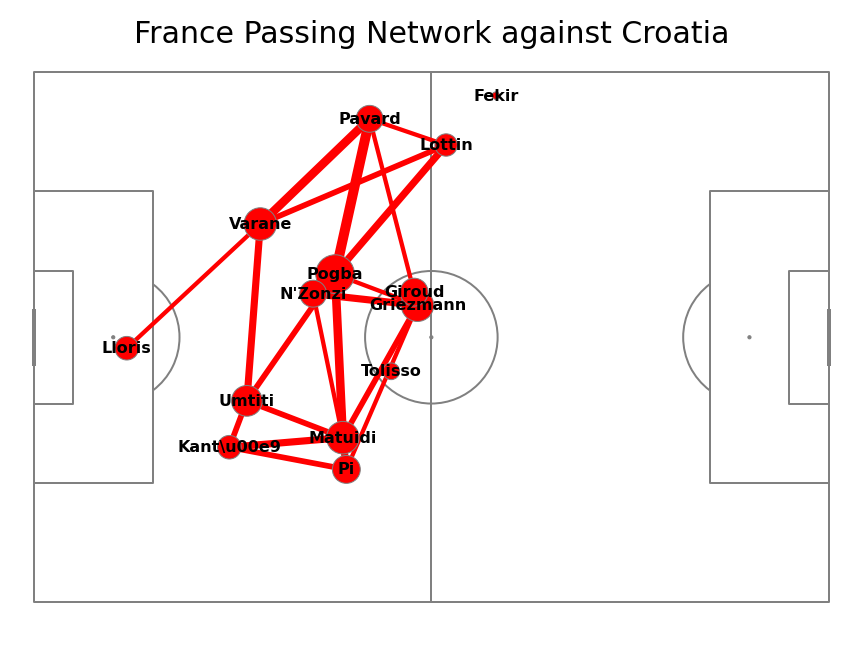

In [60]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

#counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>2]

#plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle("France Passing Network against Croatia", fontsize = 30)
plt.show()

In [63]:
mask_croatia = (acoes.type_name == 'pass') & (acoes.team_name == "Croatia") & (acoes.result_name == "succes")
#taking necessary columns
df_pass = acoes.loc[mask_croatia, ['x', 'y', 'end_x', 'end_y', "player_name"]]
df_pass["pass_recipient_name"] = proximos_jogadores
#adjusting that only the surname of a player is presented.
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

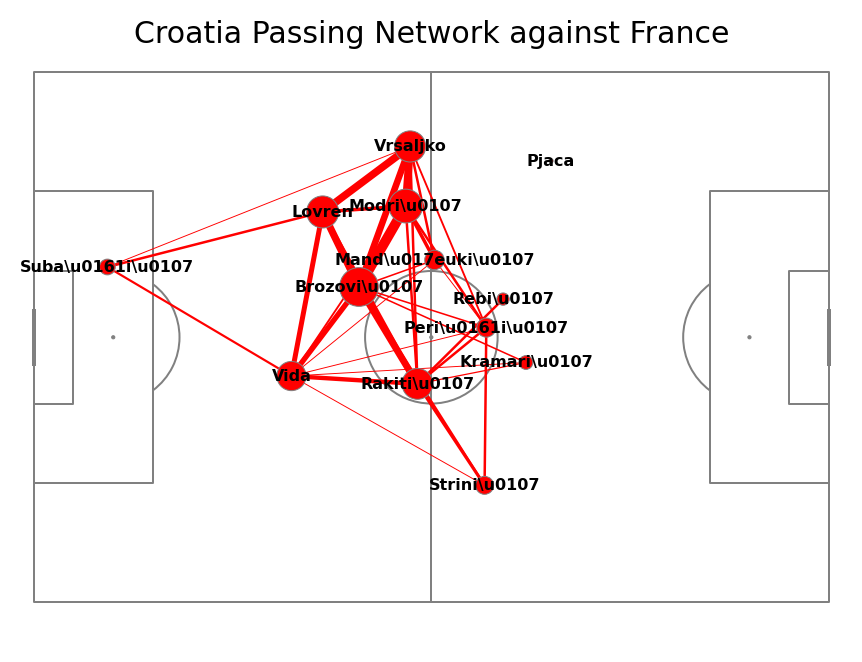

In [64]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

#counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>2]

#plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle("Croatia Passing Network against France", fontsize = 30)
plt.show()

A França parece adotar um esquema de jogo 4-5-1. Pelo gráfico, fica difícil inferir o sistema tático da Croacia. 
Percebe-se que o jogador mais participativo (o que possui maior grau) da França parece ser o Pogba, enquanto, como esperado, o destaque da Croacia é o Modric.